In [3]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp
import time

In [4]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"
NICER_1_data = "/home/tplohr/proj/SF 24-25/data/J0030_Amsterdam_2019.dat"
NICER_2_data = "/home/tplohr/proj/SF 24-25/data/J0437.dat"
LIGO_data = "/home/tplohr/proj/SF 24-25/data/GW170817.dat"

def loadfile(number):
    file = open(EOS_files + str(number) + '.dat', 'r')
    return file

In [5]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"], df["deformability"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][2] is the list of deformability values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i
#EOSs[i][2][j] is the deformability value indexed j of EOS_i

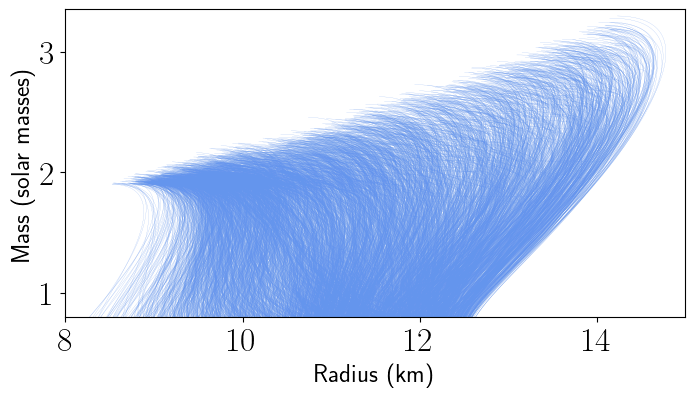

In [6]:
#plots each EOS in mass and radius
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

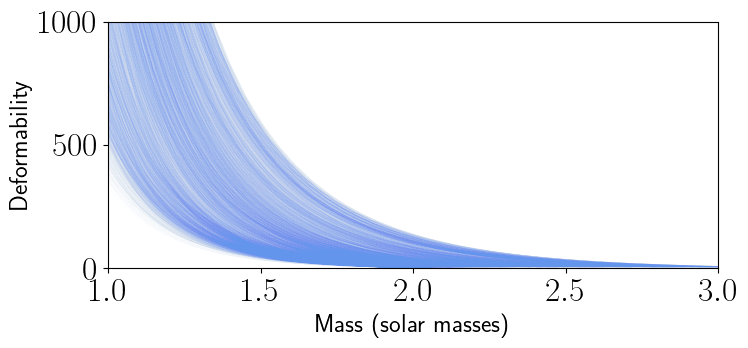

In [8]:
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    plt.xlim([1,3])
    plt.ylim([0,1000])
    plt.xlabel("Mass (solar masses)", fontsize=18)
    plt.ylabel("Deformability", fontsize=18)
    plt.plot(EOSs[i][1], EOSs[i][2], 'cornflowerblue', linewidth=.01)
plt.tight_layout()

In [9]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS
#list of radius values each EOS predicts at M=1.4
r_at_given_mass = np.zeros(numofEOS)

In [10]:
mu_1 = 2.14
mu_2 = 2.01
mu_3 = 1.908
mu_4 = 2.16
sigma_1 = 0.1
sigma_2 = 0.04
sigma_3 = 0.016
sigma_4 = 0.17
#pdf of all CDFs combined
def pdf_1_evaluate(max_m):
    return sp.stats.norm.cdf(max_m, mu_1, sigma_1) * sp.stats.norm.cdf(max_m, mu_2, sigma_2) * sp.stats.norm.cdf(max_m, mu_3, sigma_3) * (1-sp.stats.norm.cdf(max_m, mu_4, sigma_4))

In [11]:
#reading in the data from NICER dataset 1
dataframe = pd.read_csv(NICER_1_data, delim_whitespace=True, header=None)
selected_columns = dataframe.iloc[:,[1,2]]
data_NICER_1 = selected_columns.to_numpy()[:10000]
print(np.shape(data_NICER_1))
#using a KDE to get the probability density function for the likelihood
pdf_2 = sp.stats.gaussian_kde((data_NICER_1[:,1], data_NICER_1[:,0]))

(10000, 2)


In [12]:
#reading in the data from LIGO
dataframe_2 = pd.read_csv(LIGO_data, delim_whitespace=True, header=0)
selected_columns_2 = dataframe_2.iloc[:,[2,3,4,5]]
#data[:,0] is m1, data[:,1] is m2, data[:,2] is lambda1, data[:,3] is lambda2
raw_data = selected_columns_2.to_numpy()
#making data have the same shape
data_LIGO = np.copy(raw_data)
data_LIGO[:, [0,1]] = raw_data[:, [0,1]]/1.0099
data_LIGO[:, [2,3]] = raw_data[:, [2,3]]
print(np.shape(data_LIGO))
#using a KDE to get the probability density function for the likelihood
pdf_3 = sp.stats.gaussian_kde((data_LIGO[:,0], data_LIGO[:,1], data_LIGO[:,2], data_LIGO[:,3]))

(3952, 4)


In [14]:
#reading in the data from NICER dataset 2
dataframe_3 = pd.read_csv(NICER_2_data, delim_whitespace=True, header=None)
selected_columns_3 = dataframe_3.iloc[:,[0,1]]
data_NICER_2 = selected_columns_3.to_numpy()[:10000]
print(np.shape(data_NICER_2))
#using a KDE to get the probability density function for the likelihood
pdf_4 = sp.stats.gaussian_kde((data_NICER_2[:,1], data_NICER_2[:,0]))
print(data_NICER_2[:,1])

(10000, 2)
[10.2454206   9.2324232  10.19589858 ... 10.9445541  11.70510806
 10.95813562]


In [15]:
#calculate the probability of the observations given an EOS; likelihood
num_points_NICER = 1000
num_points_LIGO = 100
def calc_P_obs_given_EOS(i):
    #various mass values
    min_m = np.min(EOSs[i][1])
    max_m = np.max(EOSs[i][1])
    len_m = max_m-min_m
    
    
    ###NICER section
    #r is the interpolated function r(m)
    r = sp.interpolate.interp1d(EOSs[i][1], EOSs[i][0])
    #radius at mass 1.4 
    r_at_given_mass[i] = r(1.4)
    #important to note that num_points is set, not delta_m
    delta_m_NICER = len_m/(num_points_NICER-1)
    #m_NICER is an array of all the mass values to sum over
    m_NICER = np.linspace(min_m, max_m, num_points_NICER)

    P_NICER = 0
    #loop over each radius value space by delta_m
    for j in range(num_points_NICER):
        #probability of EOS_i, using the NICER data, is the sum of the probability of each point multiplied by the distance to the next point
        P_NICER += pdf_2.evaluate((r(m_NICER[j]), m_NICER[j])) * pdf_4.evaluate((r(m_NICER[j]), m_NICER[j])) * delta_m_NICER
    
    
    ###LIGO section
    #lambda is the interpolated function lambda(m)
    lambda_func = sp.interpolate.interp1d(EOSs[i][1], EOSs[i][2])
    #change in mass between every point
    delta_m_LIGO = len_m/(num_points_LIGO-1)
    #m_LIGO is an array of all the mass values to sum over
    m_LIGO = np.linspace(min_m, max_m, num_points_LIGO)
    
    P_LIGO = 0
    #loop over each mass value to set m1 and lambda1
    for j in range(num_points_LIGO):
        m1 = m_LIGO[j]
        lambda1 = lambda_func(m1)
        #loop over each mass value to set m2 and lambda2
        for k in range(num_points_LIGO):
            m2 = m_LIGO[k]
            lambda2 = lambda_func(m2)
            
            #probability of EOS_i is the sum of the probability of each point multiplied by the distance to the next point
            P_LIGO += pdf_3.evaluate((m1, m2, lambda1, lambda2)) * delta_m_LIGO**2
    
    
    #then multiply by the probability using the max mass constraints
    P = P_NICER * P_LIGO * pdf_1_evaluate(max_m)
    return P

In [12]:
start=time.time()
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the normalizing factor (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

#calculate the posterior
P_EOS_given_obs = P_obs_given_EOS / norm_factor
end=time.time()
print((end-start),'s', (end-start)/60, "m")

29023.244881391525 s 483.7207480231921 m


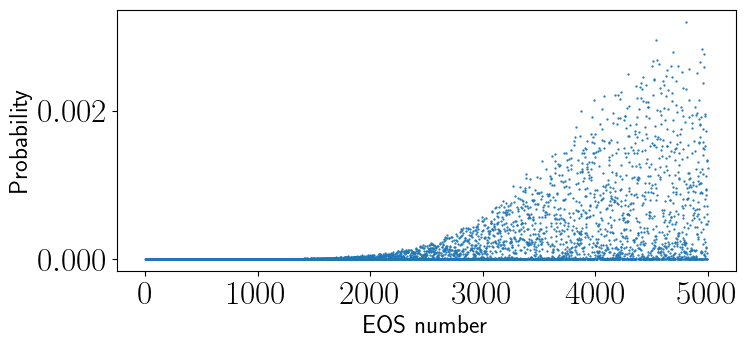

In [13]:
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/NICER_2/NICER_2_scatter_plot.png")

In [14]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

1.0000000000000018


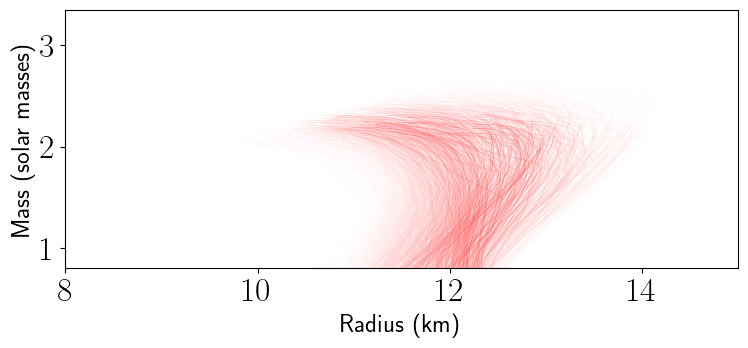

In [15]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/NICER_2/NICER_2_EOS_prob_plot.png")

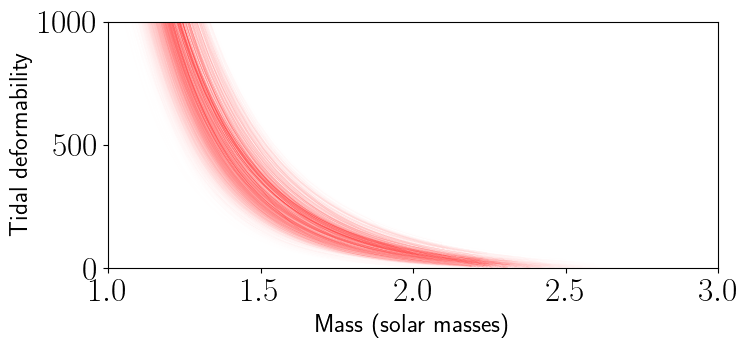

In [16]:
#plots each EOS 
plt.rcParams['figure.figsize'] = [8,4]
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([1,3])
    plt.ylim([0,1000])
    plt.ylabel("Tidal deformability", fontsize=18)
    plt.xlabel("Mass (solar masses)", fontsize=18)
    plt.plot(EOSs[i][1], EOSs[i][2], color=color, linewidth=.1)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/NICER_2/NICER_2_deformability_EOS_plot.png")

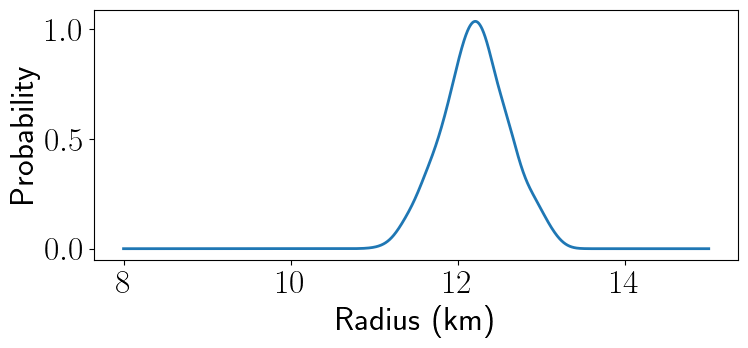

In [17]:
r_pdf = sp.stats.gaussian_kde((r_at_given_mass), weights=P_EOS_given_obs)
#plotting the radius pdf
Y = np.linspace(8, 15, 2000)
prob2=np.zeros(2000)
for i in range(2000):
    prob2[i] = r_pdf.evaluate(Y[i])
plt.xlabel("Radius (km)")
plt.ylabel("Probability")
plt.plot(Y, prob2)
plt.tight_layout()
plt.savefig("/home/tplohr/proj/SF 24-25/figs/NICER_2/NICER_2_r_PDF.png")

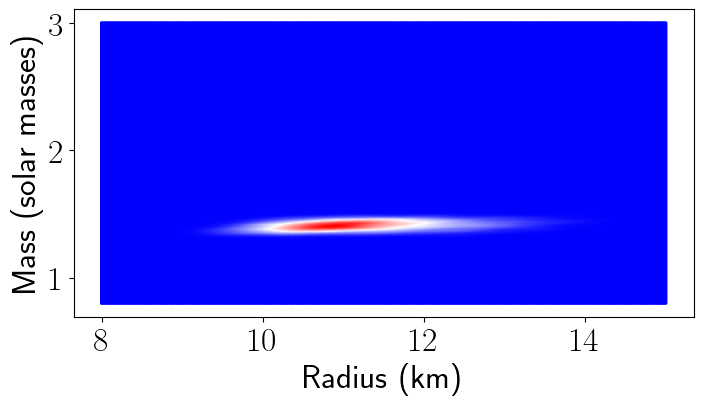

In [16]:
#plotting the pdf 
X = np.linspace(8, 15, 250)
Y = np.linspace(0.8, 3.0, 250)
points = np.zeros((250*250, 2))
prob=np.zeros(250*250)
for i in range(250):
    for j in range(250):
        points[i+j*250] = [X[i], Y[j]]
        prob[i+j*250] = pdf_4.evaluate((X[i], Y[j]))
#normalize the probabilities so the highest is always the same shade of red
norm = plt.Normalize(prob.min(), prob.max())
cmap = mp.colors.LinearSegmentedColormap.from_list("blue_white_red", ["blue", "white","red"])
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.scatter(points[:,0], points[:,1], color=cmap(norm(prob)), s=3)